<a href="https://colab.research.google.com/github/niksisons/image_processing/blob/main/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_%E2%84%962_%D0%9F%D1%80%D0%B8%D0%BC%D0%B5%D0%BD%D0%B5%D0%BD%D0%B8%D0%B5_%D0%BC%D0%B5%D1%82%D0%BE%D0%B4%D0%B0_%C2%AB%D1%81%D0%BA%D0%BE%D0%BB%D1%8C%D0%B7%D1%8F%D1%89%D0%B5%D0%B3%D0%BE_%D0%BE%D0%BA%D0%BD%D0%B0%C2%BB_%D0%B4%D0%BB%D1%8F_%D0%BF%D0%BE%D0%B8%D1%81%D0%BA%D0%B0_%D0%BE%D0%B1%D1%8A%D0%B5%D0%BA%D1%82%D0%BE%D0%B2_%D0%BD%D0%B0_%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B8_%D0%BF%D0%BE_%D1%8D%D1%82%D0%B0%D0%BB%D0%BE%D0%BD%D0%B0%D0%BC_%D0%B2_%D1%81%D1%80%D0%B5%D0%B4%D0%B5_Python_%D0%9D%D0%B5%D0%BB%D0%B8%D0%BD%D0%B5%D0%B8%CC%86%D0%BD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Практическая работа №2. Применение метода «скользящего окна» для поиска объектов на изображении по эталонам в среде Python. Нелинейные фильтры**

### **Задание №1. Найти пять зашумленных изображений и применить к ним вышеописанные фильтры. Сравнить полученные результаты. Сделать вывод для шумов какого типа целесообразней применение того или иного фильтра**

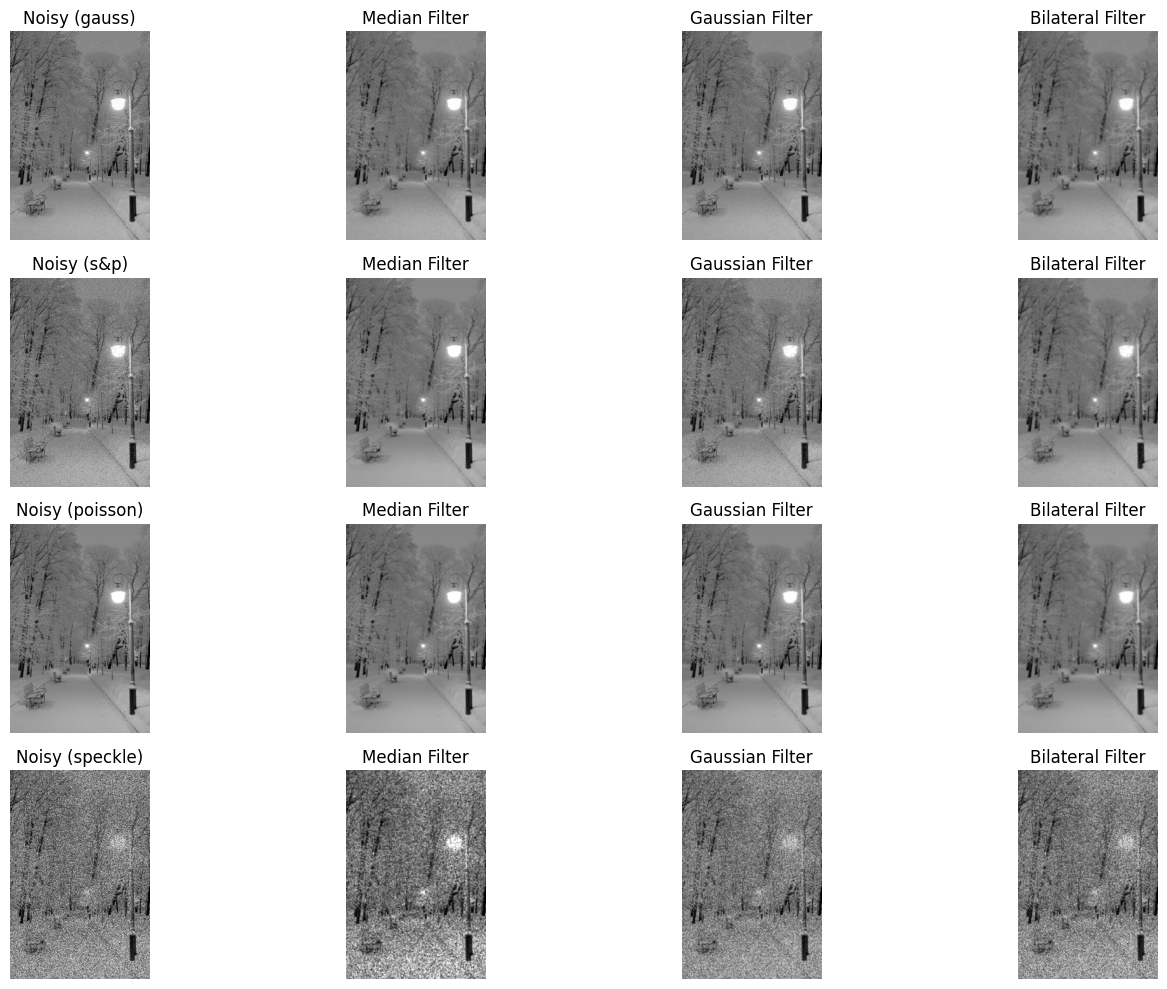

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from PIL import Image

def load_image_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('L')
    return np.array(img)

def add_noise(image, noise_type="gauss"):
    if noise_type == "gauss":
        row,col = image.shape
        mean = 0
        var = 100
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col))
        gauss = gauss.reshape(row,col)
        noisy = image + gauss
        return np.clip(noisy, 0, 255).astype(np.uint8)
    elif noise_type == "s&p":
        row,col = image.shape
        s_vs_p = 0.5
        amount = 0.04
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
        out[tuple(coords)] = 255
        # Pepper mode
        num_pepper = np.ceil(amount * image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
        out[tuple(coords)] = 0
        return out
    elif noise_type == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return np.clip(noisy, 0, 255).astype(np.uint8)
    elif noise_type =="speckle":
        row,col = image.shape
        gauss = np.random.randn(row,col)
        noisy = image + image * gauss
        return np.clip(noisy, 0, 255).astype(np.uint8)
    else:
        return image

def apply_filters(image):
    median = cv2.medianBlur(image, 5)
    gaussian = cv2.GaussianBlur(image, (5, 5), 0)
    bilateral = cv2.bilateralFilter(image, 9, 75, 75)
    return median, gaussian, bilateral

# Load a base image (replace with your image URL)
# You'll need to find 5 different base images for the task
# For demonstration, I'll use a sample image
image_url = "https://lifeo.ru/wp-content/uploads/zimnie-kartinki-na-telefon-krasivie-30-min.jpg"
original_image = load_image_from_url(image_url)

noise_types = ["gauss", "s&p", "poisson", "speckle"]
filtered_results = {}

for noise_type in noise_types:
    noisy_image = add_noise(original_image, noise_type)
    median, gaussian, bilateral = apply_filters(noisy_image)
    filtered_results[noise_type] = {
        "noisy": noisy_image,
        "median": median,
        "gaussian": gaussian,
        "bilateral": bilateral
    }

plt.figure(figsize=(15, 10))
i = 1
for noise_type, images in filtered_results.items():
    plt.subplot(len(noise_types), 4, i)
    plt.imshow(images["noisy"], cmap='gray')
    plt.title(f'Noisy ({noise_type})')
    plt.axis('off')
    i += 1

    plt.subplot(len(noise_types), 4, i)
    plt.imshow(images["median"], cmap='gray')
    plt.title('Median Filter')
    plt.axis('off')
    i += 1

    plt.subplot(len(noise_types), 4, i)
    plt.imshow(images["gaussian"], cmap='gray')
    plt.title('Gaussian Filter')
    plt.axis('off')
    i += 1

    plt.subplot(len(noise_types), 4, i)
    plt.imshow(images["bilateral"], cmap='gray')
    plt.title('Bilateral Filter')
    plt.axis('off')
    i += 1

plt.tight_layout()
plt.show()


### **Задание №2. Из подкаталога «Image_1» (каталога IMAGE), определить местонахождение всех фрагментов (Et_1.png - Et_10.png) на растре IMAGE.jpg, используя вышеописанный алгоритм. Вывести результаты в консоль по каждому эталону**

**Ссылка на Image_1: https://cloud.mail.ru/public/EA1a/sV96pAxaH**

In [5]:
import cv2
import os

main_image_path = "IMAGE.jpg"
main_image = cv2.imread(main_image_path, cv2.IMREAD_GRAYSCALE)

fragment_images = []

for i in range(1, 11):
    fragment_path = f"Et_{i}.png"
    fragment = cv2.imread(fragment_path, cv2.IMREAD_GRAYSCALE)
    fragment_images.append(fragment)

Main image and fragment images loaded successfully.


In [6]:
match_results = {}

for i, fragment in enumerate(fragment_images):
    result = cv2.matchTemplate(main_image, fragment, cv2.TM_CCOEFF_NORMED)

    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

    #using max_loc for TM_CCOEFF_NORMED
    match_results[f"Et_{i+1}.png"] = max_loc

print("Template matching completed. Results:")
for fragment_name, location in match_results.items():
    print(f"{fragment_name}: Top-left corner at {location}")

Template matching completed. Results:
Et_1.png: Top-left corner at (1434, 2283)
Et_2.png: Top-left corner at (2072, 995)
Et_3.png: Top-left corner at (1942, 2152)
Et_4.png: Top-left corner at (1242, 2267)
Et_5.png: Top-left corner at (3268, 222)
Et_6.png: Top-left corner at (4603, 501)
Et_7.png: Top-left corner at (3881, 1877)
Et_8.png: Top-left corner at (2647, 1532)
Et_9.png: Top-left corner at (3314, 240)
Et_10.png: Top-left corner at (2367, 3068)


### **Задание №3. Создать свой эталон (фрагмент), а затем определить его местонахождение на растре (по образцу из примера выше).**

**Главное при создании фрагмента учесть его разрешение.**

Можно создать эталон на сайте: https://convert-my-image.com/CropImage_Ru или используя срезы NumPy.

In [ ]:
# Ваш код